In [ ]:
from skimage.io import imread
import numpy as np
import scipy as sp
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez2_orth_basis_imgs')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez2_orth_basis_imgs'

Definition of dct2 and idct2 (they are not builtin functions)

In [ ]:
def dct2(s):
    return dct(dct(s.T, norm='ortho').T, norm='ortho')


def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

Useful function for plot the 2D DCT dictionary

In [ ]:
def get_dictionary_img(D):
    M = D.shape[0]
    p = int(round(np.sqrt(M)))
    bound = 2
    img = np.ones((p*p+bound*(p-1), p*p+bound*(p-1)))
    for i in range(M):
        m = np.mod(i, p)
        n = int((i-m)/p)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Set the patch size

In [ ]:
p = 8 # patch size
M = p ** 2 # number of elements in the patch

Load the image and extract a patch

In [ ]:
img = imread(f'./data/cameraman.png') / 255 # bring the image in [0,1] range

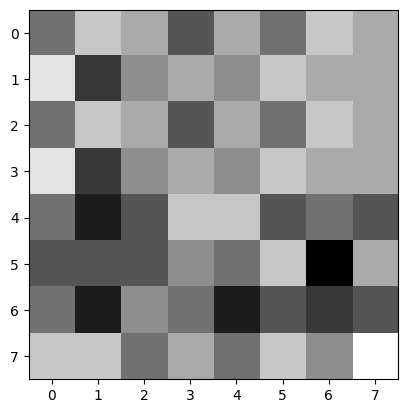

In [ ]:
img = imread(f'./data/cameraman.png') / 255 # bring the image in [0,1] range

# extract a patch from the image
s_block = img[0:p,0:p]

# unroll the patch
s = s_block.flatten()

# show the patch
plt.imshow(s_block, cmap='gray')

Compute the 2D DCT matrix (M x M)
---------------------------------
Build the matrix corresponding to the 2D DCT using the idct2 function

In [ ]:
D = np.zeros((M, M))
cnt = 0
for i in range(p):
    for j in range(p):
        a = np.zeros((p,p))
        a[i,j] = 1
        D[:, cnt] = idct2(a).flatten()
        cnt = cnt + 1

Verify that D is orthonormal

In [ ]:
is_D_orth = np.allclose(np.dot(np.transpose(D) , D), np.identity(M))
print(f'DCT dictionary is orthogonal: {is_D_orth}')
MSE = ((np.dot(np.transpose(D) , D) - np.identity(M))**2).mean()
print(f'MSE: {MSE}')

DCT dictionary is orthogonal: True
MSE: 2.634865733150531e-33


All the atoms in D can be seen as patch. Let's plot them!

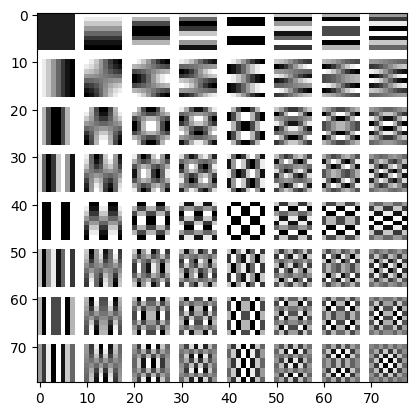

In [ ]:
D_img = get_dictionary_img(D)
plt.imshow(D_img, cmap='gray')

Compute the representation w.r.t. the 2D DCT matrix

In [ ]:
x = np.dot(np.transpose(D), s).reshape((p,p))

Separable 2D DCT
----------------
Build the 1D DCT matrix

In [ ]:
D1 = np.zeros((p, p))
for i in range(p):
    a = np.zeros(p)
    a[i] = 1
    D1[:, i] = idct(a, norm='ortho')

Compute the dct2 exploiting the separability

In [ ]:
x_block = np.dot(np.dot(np.transpose(D1), s_block), D1)

Check if the coefficient computed using the two methods are equal

In [ ]:
is_coeff_equal = np.allclose(x, x_block)
print(f'The two vectors of coefficients are the same: {is_coeff_equal}')
MSE = ((x - x_block)**2).mean()
print(f'MSE: {MSE}')

The two vectors of coefficients are the same: True
MSE: 9.390031351499299e-33


JPEG Compression
----------------
Set the threshold for the compression

In [ ]:
threshold = 0.5

Initialize the compressed image and the number of nonzero coefficients

In [ ]:
img_comp = np.zeros_like(img)
nnz_coeff = 0

Process the image patchwize

In [ ]:
for i in range(0, img.shape[0], p):
    for j in range(0, img.shape[1], p):
        # extract the patch
        s = img[i:i+p,j:j+p]

        # compute the representation w.r.t. the 2D DCT dictionary
        x = np.dot(np.dot(np.transpose(D1), s), D1)

        # perform the hard thresholding (do not perform HT on the DC!)
        x_HT = x.copy()
        x_HT[np.abs(x_HT) <= threshold] = 0
        x_HT[0,0] = x[0,0]

        # reconstruct the patch
        s_hat = idct2(x_HT)

        # put the compressed patch into the compressed image
        img_comp[i:i+p, j:j+p] = s_hat

        # update the total number of nonzero coefficient
        nnz_coeff += np.count_nonzero(x_HT)

Compute the PSNR

In [ ]:
MSE = ((img - img_comp)**2).mean()
psnr = 10 * np.log10(1/MSE)

Compute the compression ratio

In [ ]:
comp_ratio = nnz_coeff / (img.shape[0] * img.shape[1])

Show the original image and the compressed one:

Text(0.5, 1.0, 'Compressed Image,\nPSNR = 23.9540, compression_ratio = 0.0241')

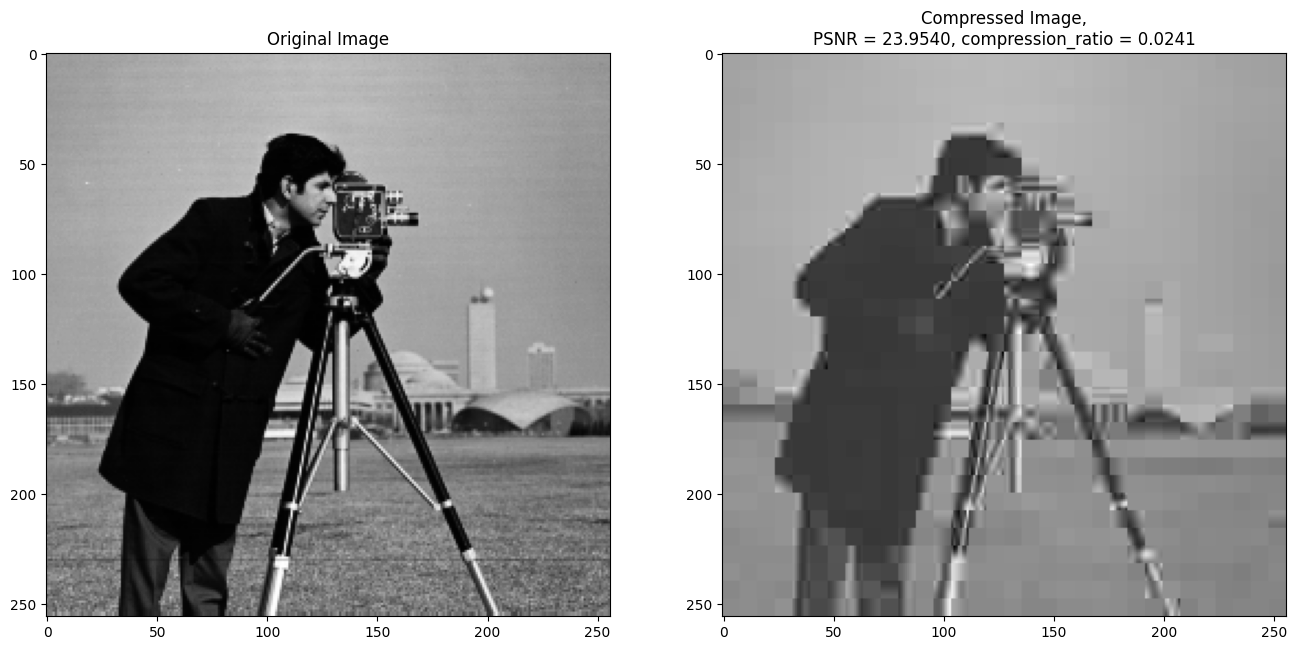

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(img_comp, cmap='gray')
ax[1].set_title(f'Compressed Image,\nPSNR = {psnr:.4f}, compression_ratio = {comp_ratio:.4f}')
